In [1]:
#importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [4]:
data_path = '/content/drive/MyDrive/Work/satellite/data'
dataset = datasets.ImageFolder(root=data_path, transform=transform)

In [5]:
class_names=dataset.classes
print(class_names)

['cloudy', 'desert', 'green_area', 'water']


In [6]:
#spliting dataset into test and train and making their dataloaders
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataset.transform = transform
test_dataset.transform = transform

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

In [21]:
def saliency_maps(model, device, data_loader, class_names):
  saliency_maps={}

  class_seen=set()
  for images, labels in data_loader:
    images, labels = images.to(device), labels.to(device)

    for i, label in enumerate(labels):
      if label.item() not in class_seen:
        class_seen.add(label.item())

        images.requires_grad_()
        outputs=model(images)
        _, predicted = torch.max(outputs.data,1)

        target_class = label.item()
        model.zero_grad()
        outputs[0, target_class].backward()

        s_map = F.relu(images.grad.data)
        saliency_maps[class_names[target_class]] = s_map.cpu().numpy()

        if len(class_seen)==len(class_names):
          break
  return saliency_maps

Model 1 - finetuned with last linear layer changed

In [8]:
#Q1
#loading pre-trained EfficientNetB4

f_model = models.efficientnet_b4(weights='DEFAULT')
#freezing pre-trained layers(except last linear layer)
for para in f_model.parameters():
  para.requires_grad=False

num_classes = 4
f_model.classifier[1] = nn.Linear(f_model.classifier[1].in_features, num_classes) #replacing last layer


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 152MB/s]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f_model = f_model.to(device)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer_f = torch.optim.Adam(f_model.classifier.parameters(), lr=0.001)

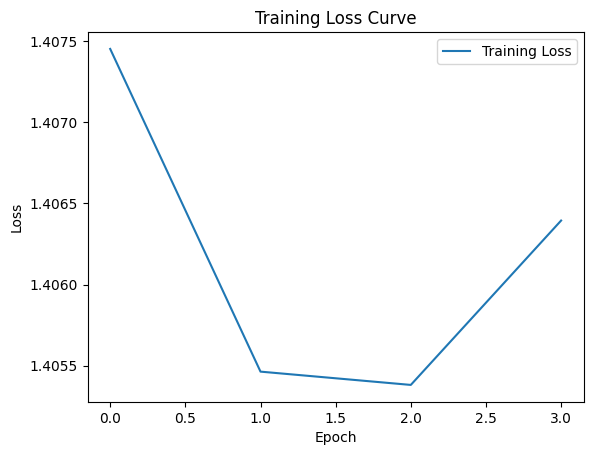

In [12]:
train_losses = []
epochs = 4

#training loop
for epoch in range(epochs):
  running_loss = 0.0

  for i,data in enumerate(train_loader,0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer_f.zero_grad()
    outputs = f_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    running_loss += loss.item()

    if i%500 == 499:
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))

  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)


#plotting training loss curve
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.show()

In [22]:
#Q2 - part 1
f_smaps = saliency_maps(f_model, device, train_loader, class_names)

Model 2 - for retraining

In [23]:
#retrained model
r_model = models.efficientnet_b4(weights='DEFAULT')
r_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [24]:
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(r_model.parameters(), lr=0.001)

[1,   100] loss: 1.406
[2,   100] loss: 1.406
[3,   100] loss: 1.406
[4,   100] loss: 1.405
[5,   100] loss: 1.406
[6,   100] loss: 1.408
[7,   100] loss: 1.406
[8,   100] loss: 1.404


ValueError: x and y must have same first dimension, but have shapes (8,) and (15,)

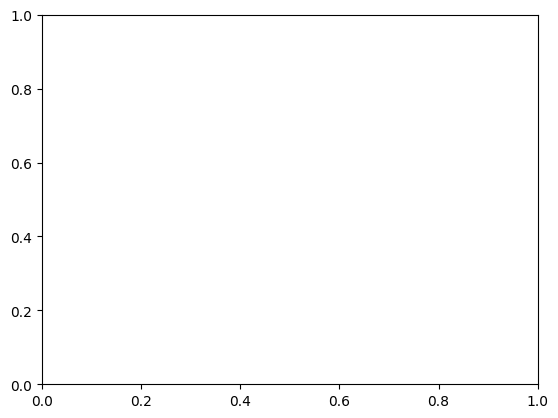

In [32]:
train_losses2 = []
epochs_ = 8

#training loop
for epoch in range(epochs_):
  running_loss = 0.0

  for i,data in enumerate(train_loader,0):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer2.zero_grad()
    outputs = f_model(inputs)
    loss = criterion2(outputs, labels)
    loss.backward()

    running_loss += loss.item()

    if i%100 == 99:
      print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
      #running_loss = 0.0
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)

#plotting training loss curve
plt.plot(range(epochs_), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curve')
plt.show()

In [33]:
#Q2 - part 2
r_smaps = saliency_maps(r_model, device, train_loader, class_names)

In [38]:
#Q3 - evaluation
def metrics(model, loader, criterion):
  device = next(model.parameters()).device
  model.eval()

  total_correct = 0
  total_samples = 0
  class_correct = [0] * 4
  class_total = [0] * 4

  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data,1)
      loss = criterion(outputs,labels)

      total_correct += (predicted==labels).sum().item()
      total_samples += labels.size(0)

      for i, label in enumerate(labels):
        class_correct[label.item()] += (predicted==label).sum().item()
        class_total[label.item()] += 1

  accuracy = total_correct / total_samples
  recall = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(len(class_correct))]

  return {
      "accuracy": accuracy,
      "recall": recall
  }

In [39]:
#eval - finetuned model 1
f_metrics = metrics(f_model, test_loader, criterion)
print(f"Fine-tuned Model - Accuracy: {f_metrics['accuracy']:.3f}, Recall (per class): {f_metrics['recall']}")

Fine-tuned Model - Accuracy: 0.179, Recall (per class): [6.4332247557003255, 6.280542986425339, 11.320689655172414, 7.313915857605178]


In [ ]:
#eval - retrained/original model 2
r_metrics = metrics(r_model, test_loader, criterion2)
print(f"Original Model - Accuracy: {r_metrics['accuracy']:.3f}, Recall (per class): {r_metrics['recall']}")

Explaination for difference in metric values:
1. pretrained EfficientNetB4 is trained on a diverse dataset of ImageNet which has thousands of classes.However, our satellite image dataset has much fewer (only 4) classes. Therefore, our fine-tuned model allows to adjust the weights to identify these specific features.
2. pretrained model may overfit directly considering our satellite image dataset is relatively smaller than what it was pretrained on. Fine-tuning last layer may help in regularizing the model.